# Parte 3: Compresión
Se importan las bibliotecas necesarias, como TensorFlow, sklearn y numpy. Además, se establece la semilla para la reproducibilidad de los resultados y se configura la variable de entorno 'PATH' para el entorno de Vivado.

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Fetch the jet tagging dataset from Open ML
Este código carga el conjunto de datos de etiquetado de jets desde archivos `.npy` y asigna las matrices de características y etiquetas, así como las clases objetivo, a las variables correspondientes.

In [8]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construcción de modelo
Se construye un modelo de red neuronal con tres capas ocultas, cada una con activación ReLU, seguidas de una capa de salida con activación softmax. Las capas ocultas tienen 64, 32 y 32 neuronas respectivamente, mientras que la capa de salida tiene 2 neuronas para clasificar en cinco clases diferentes.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

model = Sequential()
model.add(Dense(64, input_shape=(64,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(2, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Entrenamiento disperso
Este código utiliza la optimización de modelos de TensorFlow para entrenar un modelo disperso (forzando que muchos pesos sean '0'). En este caso, la esparseidad objetivo es del 75%. Se utiliza la función `prune_low_magnitude` para aplicar la poda de magnitud baja al modelo con los parámetros de poda proporcionados.

In [10]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Entrena el modelo
Utilizaremos la misma configuración que el modelo de la parte 1: el optimizador Adam con pérdida de entropía cruzada categórica. Los callbacks reducirán la tasa de aprendizaje y guardarán el modelo en un directorio 'model_2'. El modelo no es muy complejo, así que esto debería llevar solo unos minutos incluso en la CPU. Si has reiniciado el kernel del cuaderno después de entrenar una vez, establece train = False para cargar el modelo entrenado en lugar de entrenar nuevamente.

In [11]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_2',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_2/KERAS_check_best_model.h5')

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.5417
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 0.93651, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.93651, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

1/1 [==============================] - 1s 1s/step - loss: 0.7743 - accuracy: 0.5417 - val_loss: 0.9365 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.5417
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 0.93651 to 0.92570, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.93651 to 0.92570, saving model to model_2/KERAS_check_best_model_weights.h5

Ep

## Verifica la dispersión
Realiza una rápida verificación para asegurarte de que el modelo fue entrenado con dispersión. Simplemente haremos un histograma de los pesos de la primera capa y esperamos observar un pico grande en el bin que contiene '0'. Ten en cuenta que el eje y será logarítmico.

% of zeros = 0.0


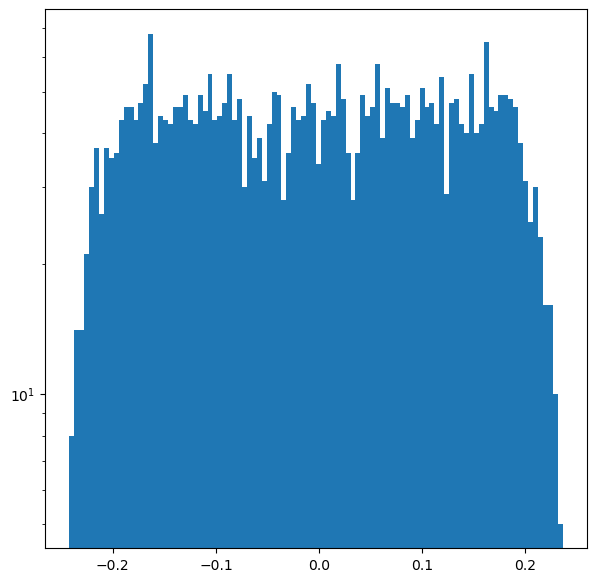

In [12]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Verifica el rendimiento
¿Cómo se compara este modelo disperso al 75% con el modelo no podado? Informemos la precisión y realicemos una curva ROC. El modelo podado se muestra con líneas sólidas, mientras que el modelo no podado de la parte 1 se muestra con líneas discontinuas. Asegúrate de haber entrenado el modelo de la parte 1.

1/1 [==============================] - 0s 36ms/step
Accuracy unpruned: 0.375
Accuracy pruned:   0.5


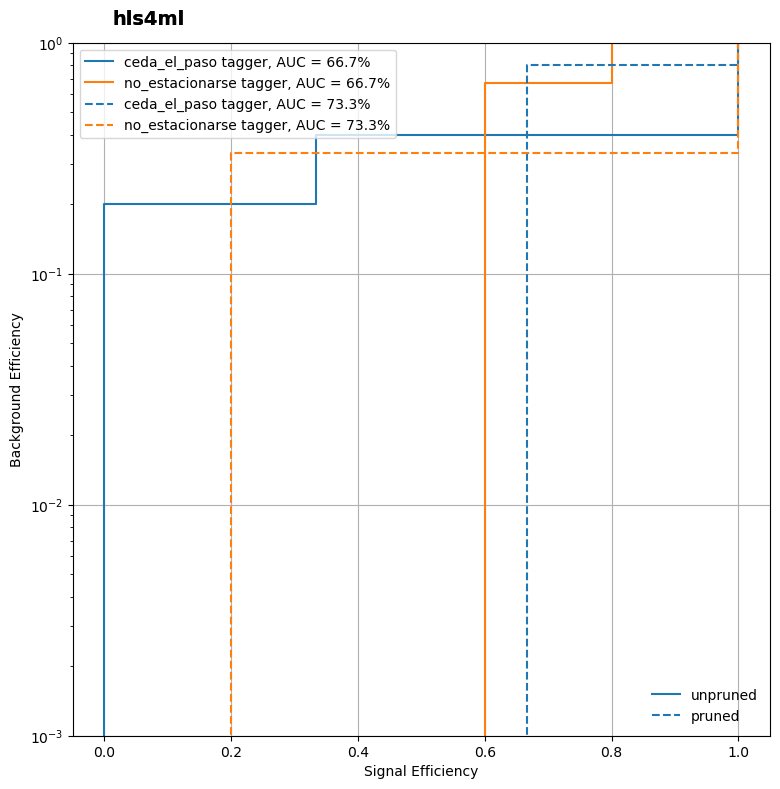

In [13]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['unpruned', 'pruned'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Convierte el modelo en firmware para FPGA con hls4ml.
Utilizaremos la configuración predeterminada: precisión ap_fixed<16,6> en todas partes y ReuseFactor=1, para que podamos compararlo con el modelo de la parte 1. Necesitamos usar strip_pruning para cambiar los tipos de capa de vuelta a sus originales.

La síntesis llevará un tiempo.

Mientras se ejecuta la síntesis C, podemos monitorear el progreso mirando el archivo de registro abriendo una terminal desde la página principal del cuaderno y ejecutando:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [14]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()
hls_model.build(csim=False)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}

Done

****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host 'c34b400bbab9' (Linux_x86_64 version 6.5.0-44-generic) on Tue Jul 30 05:02:56 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/HLS4ML/model_2/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jovyan/HLS4ML/model_2/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Addin

{}

## Verifica reportes
Verifica los informes generados por Vivado HLS. Presta atención especialmente a la sección 'Utilization Estimates'.

In [15]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Found 1 solution(s) in model_2/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


Imprime el informe del modelo entrenado en la parte 1. Recuerda que estos modelos tienen la misma arquitectura, pero el modelo en esta sección fue entrenado usando la API de sparse de tensorflow_model_optimization. Observa cómo el uso de recursos se ha reducido drásticamente (especialmente los DSP). Cuando Vivado HLS detecta una operación como y = 0 * x, puede evitar colocar un DSP para esa operación. El impacto de esto es mayor cuando ReuseFactor = 1, pero aún se aplica incluso en un reuso más alto. Ten en cuenta que debes haber entrenado y sintetizado el modelo de la parte 1.

In [16]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.
